#### Clustering asthma-related papers, among publications referring to different kind of coronaviruses

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

In [100]:
import nltk
import string
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from langdetect import detect

In [101]:
import plotly.express as px
import seaborn as sns

In [102]:
from nltk.corpus import stopwords
sw = stopwords.words("english")

The "asthma_data" csv file was created after generating the papers of interest from Kaggle community. In response to the COVID-19 pandemic a large database, the COVID-19 Open Research Dataset (CORD-19), was created and has been made publicly available. CORD-19 is a resource of hundreds of thousands scholarly articles, about COVID-19, SARS-CoV-2, and related coronaviruses.
More information about this open source can be found here:
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge


For this project, we selected only those papers where the word "asthma" appears at least once in their abstract. As long as all these publications are coronaviruses-related articles, we suppose that each one provides a different relation and among a different context, between asthma and coronaviruses. The papers were firstseparated and then downloaded, in order to be more easily handled.

Below, we convert our csv file to a pandas dataframe and we can have a look at the metadata we picked to examine. Among other information we have each paper's title, DOI, source and the abstract, which is the feature we'll basically need for this project.

In [103]:
asthma_df = pd.read_csv("asthma_data.csv")
asthma_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_lower,title_lower
0,qva0jt86,4ba79e54ecf81b30b56461a6aec2094eaf7b7f06,PMC,Relevance of human metapneumovirus in exacerba...,10.1186/1465-9921-6-150,PMC1334186,16371156.0,cc-by,BACKGROUND AND METHODS: Human metapneumovirus ...,2005-12-21,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/4ba79e54ecf81b30b5646...,document_parses/pmc_json/PMC1334186.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,background and methods: human metapneumovirus ...,relevance of human metapneumovirus in exacerba...
1,chz8luni,d68d71553d3a31381c0c3851351f912a9a7be1c9,PMC,Surfactant therapy for acute respiratory failu...,10.1186/cc5944,PMC2206432,17573963.0,cc-by,INTRODUCTION: Exogenous surfactant is used to ...,2007-06-15,...,Crit Care,NaN,NaN,NaN,document_parses/pdf_json/d68d71553d3a31381c0c3...,document_parses/pmc_json/PMC2206432.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,introduction: exogenous surfactant is used to ...,surfactant therapy for acute respiratory failu...
2,3zh8jmc2,fe2000f280297c40bc53ce95d703a9ca6aac19fd,PMC,Differential Regulation of Type I Interferon a...,10.1371/journal.ppat.1000587,PMC2736567,19806178.0,cc-by,A number of paramyxoviruses are responsible fo...,2009-09-18,...,PLoS Pathog,NaN,NaN,NaN,document_parses/pdf_json/fe2000f280297c40bc53c...,document_parses/pmc_json/PMC2736567.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,a number of paramyxoviruses are responsible fo...,differential regulation of type i interferon a...
3,7p3b6tyf,3ccbd07ee1865e4f2afffdb6cc8b6039ab605ee7,PMC,The Tennessee Children's Respiratory Initiativ...,10.1111/j.1440-1843.2010.01743.x,PMC2992986,20409023.0,no-cc,Background and objective: The ‘attack rate’ of...,2010-04-08,...,Respirology,NaN,NaN,NaN,document_parses/pdf_json/3ccbd07ee1865e4f2afff...,document_parses/pmc_json/PMC2992986.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,background and objective: the ‘attack rate’ of...,the tennessee children's respiratory initiativ...
4,xrsyj1tc,fa88fbb8716e5fca7d513bcb5a0a608456a59205,PMC,Analysing the eosinophil cationic protein - a ...,10.1186/1465-9921-12-10,PMC3030543,21235798.0,cc-by,Eosinophil granulocytes reside in respiratory ...,2011-01-14,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/fa88fbb8716e5fca7d513...,document_parses/pmc_json/PMC3030543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,eosinophil granulocytes reside in respiratory ...,analysing the eosinophil cationic protein - a ...


There are 2567 papers containing the word "asthma", among the coronavirus-related publications 

In [104]:
asthma_df.shape

(2567, 21)

Between these docs, there are papers written in english, french, german language and perhaps some more. In this project,for simplicity reasons, we keep only these papers written in english. Like that, we avoid having, later on, clusters of papers only of the same langugae but which have not nevessarily similar context.

To do so, we use the *langdetect* google library to dect the language of the "abstract" column in our dataframe.

In [105]:
asthma_df["lang_detect"] = asthma_df["abstract"].apply(detect)

In [106]:
asthma_df["lang_detect"].value_counts()

en    2530
de      12
fr      11
es       7
ru       3
pt       2
nl       2
Name: lang_detect, dtype: int64

We now have 2528 papers in total, written in english.

In [107]:
asthma_df = asthma_df.loc[asthma_df['lang_detect'] == "en"]
asthma_df.shape

(2530, 22)

We can also have a quick look at the sources where the papers came from:

In [108]:
asthma_after_covid['source_x'].value_counts()

WHO                              688
Medline; PMC                     302
Medline                          221
Elsevier; Medline; PMC           124
MedRxiv; WHO                      62
PMC                               60
Elsevier; PMC                     10
BioRxiv; WHO                       7
ArXiv                              6
MedRxiv                            6
BioRxiv                            5
MedRxiv; Medline; WHO              4
Medline; PMC; WHO                  4
MedRxiv; Medline; PMC; WHO         3
Elsevier; Medline; PMC; WHO        2
PMC; WHO                           1
ArXiv; Elsevier; Medline; PMC      1
Name: source_x, dtype: int64

We divide the papers between those published before the new coronavirus SARS-CoV-2 has appeared and those published after the COVID-19 outbreak. We pick December 2019 as the cut-off date.

In [109]:
asthma_before_covid = asthma_df.loc[asthma_df['publish_time']<"2019-12-01"].reset_index(drop=True)
asthma_after_covid = asthma_df.loc[asthma_df['publish_time']>="2019-12-01"].reset_index(drop=True)

We can also have a look at the number of the papers published by month, since the covid outbreak. 

In [110]:
asthma_after_covid['publish_time_new'] =  pd.to_datetime(asthma_after_covid['publish_time'])

In [111]:
asthma_after_covid['publish_month_year'] = pd.to_datetime(asthma_after_covid['publish_time']).dt.to_period('M')
asthma_after_covid.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_lower,title_lower,lang_detect,publish_time_new,publish_month_year
0,3ki0dzwb,71b8c50ee0e1f4e79e6618301b768befbf943a5d,PMC,Inflammatory and microbiological associations ...,10.1183/23120541.00267-2019,PMC6983494,32010717.0,cc-by-nc,Patients with near-fatal asthma requiring ECMO...,2020-01-27,...,NaN,document_parses/pdf_json/71b8c50ee0e1f4e79e661...,document_parses/pmc_json/PMC6983494.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,patients with near-fatal asthma requiring ecmo...,inflammatory and microbiological associations ...,en,2020-01-27,2020-01
1,okc7wf4n,f4edbfd3e9a8b2d0d76378e6588a5971b070a4c9,PMC,Different effects of acetyl-CoA carboxylase in...,10.1007/s43440-019-00027-8,PMC7223088,32048254.0,no-cc,BACKGROUND AND OBJECTIVE: Acetyl CoA carboxyla...,2020-01-08,...,NaN,document_parses/pdf_json/f4edbfd3e9a8b2d0d7637...,document_parses/pmc_json/PMC7223088.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,background and objective: acetyl coa carboxyla...,different effects of acetyl-coa carboxylase in...,en,2020-01-08,2020-01
2,8lqjl0ee,1f6fa8e138abc1556e853c53dcce8f5e16007fcc,PMC,Risk of Readmission and Mortality Following Ho...,10.1007/s00408-019-00300-w,PMC7223622,31828514.0,no-cc,PURPOSE: Hypercapnic respiratory failure (HRF)...,2019-12-11,...,NaN,document_parses/pdf_json/1f6fa8e138abc1556e853...,document_parses/pmc_json/PMC7223622.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,purpose: hypercapnic respiratory failure (hrf)...,risk of readmission and mortality following ho...,en,2019-12-11,2019-12
3,vosu7y6j,6fa9233f054f4bbb31972e05c1478b0ec83ccc16,PMC,Innate Type 2 Responses to Respiratory Syncyti...,10.3390/v12050521,PMC7290766,32397226.0,cc-by,Respiratory syncytial virus (RSV) is a common ...,2020-05-08,...,NaN,document_parses/pdf_json/6fa9233f054f4bbb31972...,document_parses/pmc_json/PMC7290766.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,respiratory syncytial virus (rsv) is a common ...,innate type 2 responses to respiratory syncyti...,en,2020-05-08,2020-05
4,yyw64g9w,8d634bba632c08e7d8e105a66dac4e0d813ab4e9,PMC,From Mouse to Man and Back: Closing the Correl...,10.3390/diagnostics10090636,PMC7554749,32859103.0,cc-by,"Lung diseases such as fibrosis, asthma, cystic...",2020-08-26,...,NaN,document_parses/pdf_json/8d634bba632c08e7d8e10...,document_parses/pmc_json/PMC7554749.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,"lung diseases such as fibrosis, asthma, cystic...",from mouse to man and back: closing the correl...,en,2020-08-26,2020-08


In [112]:
asthma_after_covid = asthma_after_covid.sort_values('publish_month_year')

In [113]:
dates = asthma_after_covid["publish_month_year"].value_counts()

In [114]:
dates_df = dates.to_frame().reset_index()

In [115]:
dates_df = dates_df.sort_values("index")
dates_df

,index,publish_month_year
12,2019-12,10
0,2020-01,601
13,2020-02,9
14,2020-03,8
11,2020-04,19
8,2020-05,69
7,2020-06,74
3,2020-07,92
9,2020-08,60
4,2020-09,90


The graph below illustrates the number of papers published through the last 12-14 months. However, we recognize that the two picks noticed in January 2020 and January 2021 are not completely accurate. As an amount of papers had only the year (yyyy) mentioned in their publication date, the date is converetd to 01/01/yyyy. We keep in mind that it's very possible that not all of these papers were published in January. 

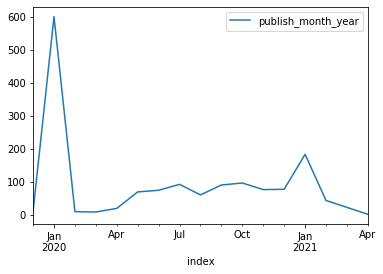

In [116]:
dates_df.plot(x ='index', y = 'publish_month_year')

## Clustering

The aim of this part of the project is cluster the papers published before and after the outbreak of the pandemic. Doing that, we aim to group papers with similar context based on their text.  

Below, for both these two groups of papers (before and after COVID-19 outbreak), we follow the same data processing. The steps followed are:

* Tokenization of the papers' abstracts text
* Stemming of the tokens 
* Use of the TfidfVectorizer 

In [117]:
texts_before = asthma_before_covid["abstract_lower"].tolist()

In [118]:
def custom_tokenizer(str_input):
    
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(str_input)
    words = [word for word in words if word.lower() not in sw]

    words = [word.replace('â¡', '') for word in words]
    words = [word.replace('â¢', '') for word in words]
    words = [word.replace('â£', '') for word in words]
    
    words = [''.join(c for c in word if c not in string.punctuation+'©±×≤≥●＜--“”→„') for word in words]
    words = [word for word in words if word not in ['‘', '’', '„']]
        
    words = [word for word in words if word]
    words = [word for word in words if not any(char.isdigit() for char in word)]
    
    #remove stop words before stemming - nltk list of stop words - read file and tolist
    words = [stemmer.stem(word) for word in words]
    return words

In [119]:

custom_tokenizer(string_test)

['wilson',
 'tour',
 'tenni',
 'racket',
 'wilson',
 'tour',
 'tenni',
 'racket',
 'fantast',
 'choic',
 'new',
 'starter',
 'sport',
 'lightweight',
 'frame',
 'allow',
 'easi',
 'swing',
 'grip',
 'handl',
 'promot',
 'comfort',
 'feel',
 'assist',
 'control',
 'shot']

In [120]:
vec_before = TfidfVectorizer(min_df=5,tokenizer=custom_tokenizer,
                             max_features=2000,
                      stop_words='english')
matrix_before = vec_before.fit_transform(texts_before)
df_before = pd.DataFrame(matrix_before.toarray(), columns=vec_before.get_feature_names())
df_before.head()

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



,aberr,abil,abl,abnorm,absenc,absent,absolut,absorpt,abstract,abund,...,x,xray,year,yield,young,younger,yr,α,β,–
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.039254,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.035466,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The Kmeans is explained here:
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [121]:
number_of_clusters=10
km_before = KMeans(n_clusters=number_of_clusters)
km_before.fit(matrix_before)

KMeans(n_clusters=10)

Let's have an over view of our cluster's centers (centroids) anf labels. After that, we get the top terms for every cluster. In other wrods, we see which are the most frequently mentioned words per cluster. Note: since we have used Stemming, we only have the root of the words now.

In [122]:
centroids_before, labels_before = km_before.cluster_centers_, km_before.labels_
print(centroids_before)
print(labels_before)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00577673 0.         ... 0.         0.         0.        ]
 [0.         0.00020416 0.00200471 ... 0.00081609 0.00177248 0.00549528]
 ...
 [0.00189881 0.0028323  0.0012462  ... 0.00160351 0.00452261 0.00816807]
 [0.0007639  0.00470215 0.00230843 ... 0.00134029 0.00181803 0.00227231]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[3 2 4 ... 7 2 6]


In [123]:
print("Top terms per cluster:")
order_centroids_before = km_before.cluster_centers_.argsort()[:, ::-1]
terms = vec_before.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_before[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: airway inflamm inflammatori lung mice asthma diseas respons role rhinosinus chronic hyperrespons tlr allerg activ infect increas vitamin receptor cell
Cluster 1: hrv hrvc children infect hrva detect human strain respiratori asthma associ speci exacerb ill caus rhinovirus p identifi group type
Cluster 2: patient ci asthma use p hospit sever year failur treatment respiratori corticosteroid acut care admiss ventil studi day children risk
Cluster 3: children respiratori detect infect virus viru hmpv patient rhinoviru rsv exacerb hospit clinic sampl viral hbov asthma human tract acut
Cluster 4: cell express protein infect activ airway epitheli respons diseas gene macrophag human lung immun function inflammatori inhibit regul induc role
Cluster 5: p subject exacerb asthma patient eosinophil level infect sputum asthmat group viral airway increas day control cold serum nasal significantli
Cluster 6: wheez children bronchiol infant risk asthma recurr respirator

In [124]:
order_centroids_before
#word with index 1049 has highest Tfidf value in the first array

array([[  69,  916,  917, ..., 1118, 1119,    0],
       [ 833,  836,  287, ..., 1161, 1162,    0],
       [1310,  295,  149, ..., 1485,  586,    0],
       ...,
       [ 524,  149,  798, ...,  234, 1529, 1207],
       [ 651,  913,  149, ..., 1272, 1274,  999],
       [1360,  919, 1310, ..., 1118, 1121,    0]], dtype=int64)

PCA and its implementation in Python is explained here: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [125]:
T = preprocessing.Normalizer().fit_transform(df_before)
# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(T) 
T = pca_model.transform(T) 

# transform the 'centroids of KMean'

centroid_pca = pca_model.transform(centroids_before)


In [126]:
asthma_before_covid['labels'] = km_before.labels_
asthma_before_covid['pca_1'] = T[:, 0]
asthma_before_covid['pca_2'] = T[:, 1]

In [127]:
asthma_before_covid['labels'] = asthma_before_covid['labels'].astype(str)

In [128]:
fig = px.scatter(asthma_before_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="labels",
                 hover_data=['title'])

In [129]:
fig.show()

#### After covid-19

In [130]:
texts_after = asthma_after_covid["abstract_lower"].tolist()

In [131]:
vec_after = TfidfVectorizer(tokenizer=custom_tokenizer,
                      stop_words='english', 
                           max_features=1000)
matrix_after = vec_after.fit_transform(texts_after)
df_after = pd.DataFrame(matrix_after.toarray(), columns=vec_after.get_feature_names())


c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



In [132]:
df_after.head()

,abil,abl,abnorm,absenc,abstract,access,accord,account,accumul,achiev,...,world,worldwid,wors,worsen,wuhan,year,york,young,younger,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.076611,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [133]:
number_of_clusters=10
km_after = KMeans(n_clusters=number_of_clusters)
km_after.fit(matrix_after)
km_after.fit

<bound method KMeans.fit of KMeans(n_clusters=10)>

In [134]:
centroids_after, labels_after = km_after.cluster_centers_, km_after.labels_
print(centroids_after)
print(labels_after)

[[0.00139597 0.         0.         ... 0.00366921 0.00453343 0.        ]
 [0.00191288 0.00506414 0.00084934 ... 0.00384571 0.00302756 0.00580706]
 [0.00074961 0.00050007 0.00598586 ... 0.002958   0.00563359 0.00081884]
 ...
 [0.00456124 0.00482093 0.00765665 ... 0.00070926 0.         0.        ]
 [0.00256451 0.00496591 0.         ... 0.00345558 0.         0.        ]
 [0.00827315 0.00152138 0.0026713  ... 0.00093563 0.00200251 0.        ]]
[8 9 0 ... 0 3 9]


In [135]:
print("Top terms per cluster:")
order_centroids_after = km_after.cluster_centers_.argsort()[:, ::-1]
terms = vec_after.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_after[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ci diseas risk factor age mortal death diabet sever adult comorbid women patient hospit associ chronic higher hr icu cancer
Cluster 1: health asthma care patient pandem diseas use telemedicin allergi provid studi visit measur individu symptom condit healthcar practic includ risk
Cluster 2: patient hospit p studi diseas age comorbid mortal asthma clinic admiss group outcom vs year ci risk associ test sever
Cluster 3: express cell gene airway epitheli asthma asthmat copd receptor bronchial sever allerg diseas blood level lung infect upregul increas associ
Cluster 4: case patient present diseas report coronaviru day symptom acut respiratori infect sever cough bilater pregnant histori pneumonia ct test chest
Cluster 5: air pollut health lockdown exposur impact human qualiti particul reduc asthma environment citi matter econom respiratori effect level children chang
Cluster 6: children asthma infect respiratori pediatr wheez studi year symptom hospit sever 

In [136]:
order_centroids_after

array([[146, 261, 789, ..., 453, 465, 499],
       [387,  77, 123, ..., 585, 894, 725],
       [633, 401, 618, ..., 537,  85, 616],
       ...,
       [ 13, 539, 171, ..., 540, 541, 499],
       [633,  77, 828, ..., 379, 367, 499],
       [261, 512, 777, ..., 315, 852, 999]], dtype=int64)

In [137]:
T_after = preprocessing.Normalizer().fit_transform(df_after)
# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(T_after) 
T_after = pca_model.transform(T_after) 

centroid_pca_after = pca_model.transform(centroids_after)

In [138]:
asthma_after_covid['labels'] = km_after.labels_
asthma_after_covid['pca_1'] = T_after[:, 0]
asthma_after_covid['pca_2'] = T_after[:, 1]

In [139]:
asthma_after_covid['labels'] = asthma_after_covid['labels'].astype(str)

In [140]:
fig = px.scatter(asthma_after_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="labels",
                 hover_data=['title'])

In [141]:
fig.show()